In [ ]:
# !pip install segmentation_models segmentation_models_pytorch timm monai medpy torchmetrics albumentations imagecodecs einops

# Taller 2

In [ ]:
import os, json, random
from PIL import Image

import itertools, warnings, math, gc, pandas, numpy, time
import numpy as np, pandas as pd, tensorflow as tf, cv2, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, balanced_accuracy_score, confusion_matrix
import torch, tifffile as tiff
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision.models.detection import maskrcnn_resnet50_fpn
import segmentation_models_pytorch as smp, timm, monai
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from scipy.spatial.distance import directed_hausdorff
from medpy.metric.binary import hd95
from skimage.draw import polygon
import torch.multiprocessing as mp

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0); np.random.seed(0); torch.manual_seed(0)

mp.set_start_method("spawn", force=True)

In [ ]:
device

## Punto 4

### Parte A

In [ ]:

meta_tiles = pd.read_csv('tile_meta.csv')
meta_wsi = pd.read_csv('wsi_meta.csv')

with open('polygons.jsonl') as f:
    anotaciones = [json.loads(l) for l in f]

df_anot = pd.json_normalize(anotaciones, 'annotations', ['id'])
df_anot['area_px'] = df_anot['coordinates'].apply(lambda ls: sum(cv2.contourArea(np.array(p, np.int32)) for p in ls))

df_anot

type                                        coordinates  \
0        glomerulus  [[[167, 249], [166, 249], [165, 249], [164, 24...   
1      blood_vessel  [[[283, 109], [282, 109], [281, 109], [280, 10...   
2      blood_vessel  [[[104, 292], [103, 292], [102, 292], [101, 29...   
3      blood_vessel  [[[505, 442], [504, 442], [503, 442], [502, 44...   
4      blood_vessel  [[[375, 477], [374, 477], [373, 477], [372, 47...   
...             ...                                                ...   
17513  blood_vessel  [[[184, 308], [183, 308], [182, 308], [181, 30...   
17514  blood_vessel  [[[42, 92], [41, 92], [40, 92], [39, 92], [38,...   
17515  blood_vessel  [[[287, 480], [286, 480], [285, 480], [284, 48...   
17516  blood_vessel  [[[493, 388], [492, 388], [491, 388], [490, 38...   
17517  blood_vessel  [[[64, 15], [63, 15], [62, 15], [61, 15], [61,...   

                 id  area_px  
0      0006ff2aa7cd  55942.5  
1      0006ff2aa7cd    521.0  
2      0006ff2aa7cd    939.5  
3      0006ff2aa7cd    928.5  
4      0006ff2aa7cd    963.5  
...             ...      ...  
17513  ffd3d193c71e    360.0  
17514  ffd3d193c71e    661.0  
17515  ffd3d193c71e    342.5  
17516  ffd3d193c71e   1643.5  
17517  ffd3d193c71e    158.5  

[17518 rows x 4 columns]

In [ ]:
meta_tiles

id  source_wsi  dataset      i      j
0     0006ff2aa7cd           2        2  16896  16420
1     000e79e206b7           6        3  10240  29184
2     00168d1b7522           2        2  14848  14884
3     00176a88fdb0           7        3  14848  25088
4     0033bbc76b6b           1        1  10240  43008
...            ...         ...      ...    ...    ...
7028  ffd37b5c6598          13        3  13824  21504
7029  ffd3d193c71e           3        2   7680  16896
7030  ffd77e2517af          13        3  15872  28160
7031  ffe3cbb81f72          10        3  15456  23000
7032  ffe40e3bc324           9        3  13824  19456

[7033 rows x 5 columns]

In [ ]:
meta_wsi

source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

In [ ]:
df_anot_agr = df_anot.groupby(['id', 'type'])['area_px'].sum().unstack(fill_value=0).reset_index()
df_anot_agr

type            id  blood_vessel  glomerulus  unsure
0     0006ff2aa7cd       10051.0     55942.5     0.0
1     00168d1b7522        1557.5     20416.0     0.0
2     0033bbc76b6b        2891.0         0.0  2619.0
3     003504460b3a        1969.5         0.0     0.0
4     004daf1cbe75        4886.5     37870.5     0.0
...            ...           ...         ...     ...
1628  ff434af74304        5495.5         0.0     0.0
1629  ff4897b3eda6        7093.5         0.0     0.0
1630  ff66dec71c4c       21842.0      2035.0     0.0
1631  ff99cdef0f2a        3630.5      3017.5     0.0
1632  ffd3d193c71e        3165.5    141444.0     0.0

[1633 rows x 4 columns]

In [ ]:
print('Estadísticas globales')
print('Total tiles', len(meta_tiles))
print('Total WSIs', meta_tiles['source_wsi'].nunique())


meta_tiles['dataset'].value_counts()

Estadísticas globales
Total tiles 7033
Total WSIs 13


dataset
3    5400
2    1211
1     422
Name: count, dtype: int64

In [ ]:
meta_tiles[['i', 'j']].describe()

i             j
count   7033.000000   7033.000000
mean   14296.542585  23227.014930
std     5946.054578  10644.032931
min     1536.000000   2560.000000
25%     9728.000000  15265.000000
50%    13824.000000  22528.000000
75%    18944.000000  29656.000000
max    30208.000000  52753.000000

In [ ]:
print('Distribución de anotaciones por tipo')
df_anot['type'].value_counts()


Distribución de anotaciones por tipo


type
blood_vessel    16054
unsure            897
glomerulus        567
Name: count, dtype: int64

In [ ]:
print('Cobertura promedio de máscara por tile')
df_anot_agr[['blood_vessel', 'glomerulus', 'unsure']].mean() / (512 * 512)

Cobertura promedio de máscara por tile


type
blood_vessel    0.043463
glomerulus      0.045918
unsure          0.004662
dtype: float64

In [ ]:

sin_mask = set(meta_tiles['id']) - set(df_anot['id'])
print('Tiles sin máscara', len(sin_mask))


Tiles sin máscara 5400


In [ ]:
df_anot_agr['ratio_bv'] = df_anot_agr['blood_vessel'] / (512 * 512)
an_bajas = df_anot_agr.query('ratio_bv < 0.0005 and ratio_bv > 0')
an_altas = df_anot_agr.query('ratio_bv > 0.9')

df_anot_agr

type            id  blood_vessel  glomerulus  unsure  ratio_bv
0     0006ff2aa7cd       10051.0     55942.5     0.0  0.038342
1     00168d1b7522        1557.5     20416.0     0.0  0.005941
2     0033bbc76b6b        2891.0         0.0  2619.0  0.011028
3     003504460b3a        1969.5         0.0     0.0  0.007513
4     004daf1cbe75        4886.5     37870.5     0.0  0.018641
...            ...           ...         ...     ...       ...
1628  ff434af74304        5495.5         0.0     0.0  0.020964
1629  ff4897b3eda6        7093.5         0.0     0.0  0.027060
1630  ff66dec71c4c       21842.0      2035.0     0.0  0.083321
1631  ff99cdef0f2a        3630.5      3017.5     0.0  0.013849
1632  ffd3d193c71e        3165.5    141444.0     0.0  0.012075

[1633 rows x 5 columns]

In [ ]:
an_bajas

type            id  blood_vessel  glomerulus  unsure  ratio_bv
1139  b3ee5e7bcf74          85.5         0.0     0.0  0.000326
1232  c35d853b0cd2          93.5         0.0     0.0  0.000357

In [ ]:
an_altas

Empty DataFrame
Columns: [id, blood_vessel, glomerulus, unsure, ratio_bv]
Index: []

In [ ]:
print('Posibles anomalías baja cobertura', len(an_bajas))
print('Posibles anomalías alta cobertura', len(an_altas))

Posibles anomalías baja cobertura 2
Posibles anomalías alta cobertura 0


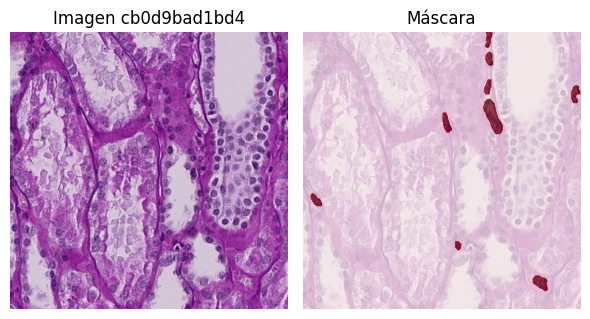

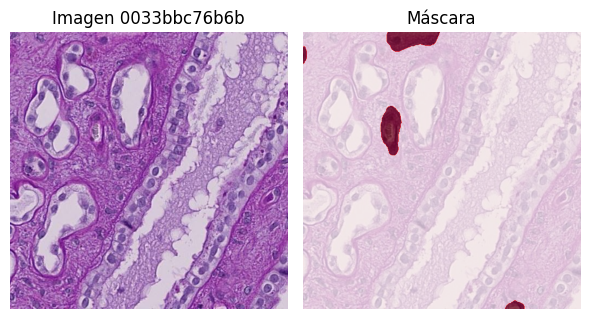

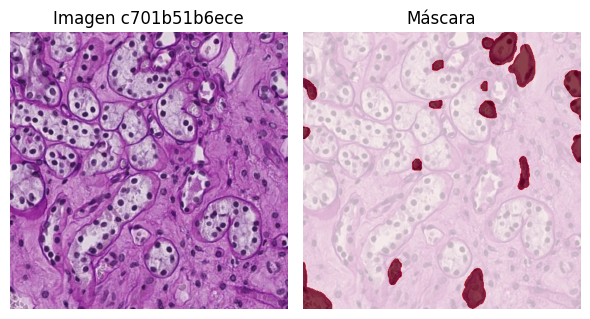

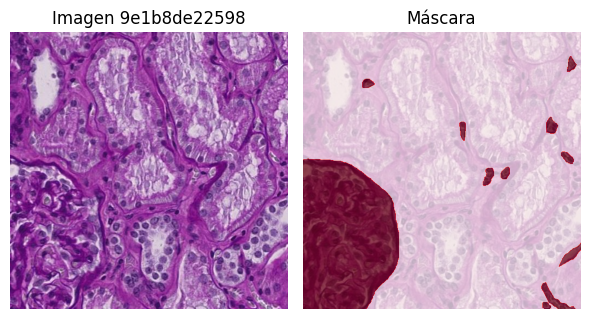

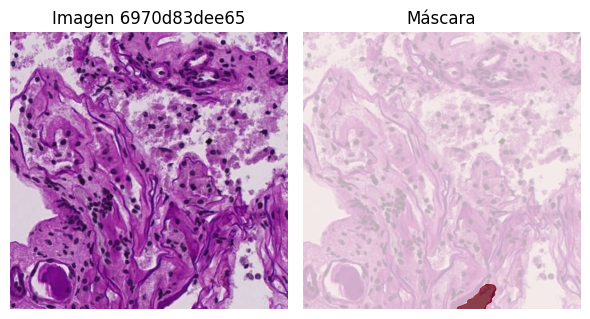

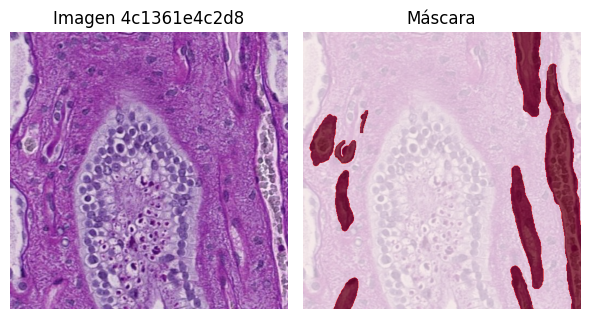

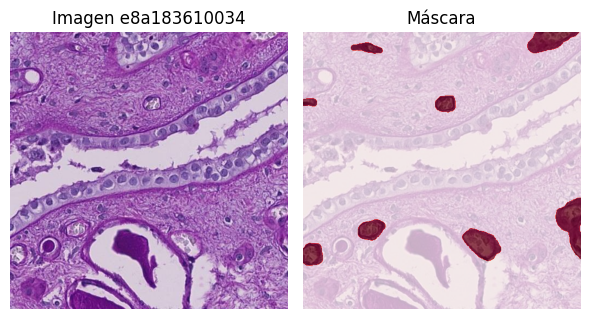

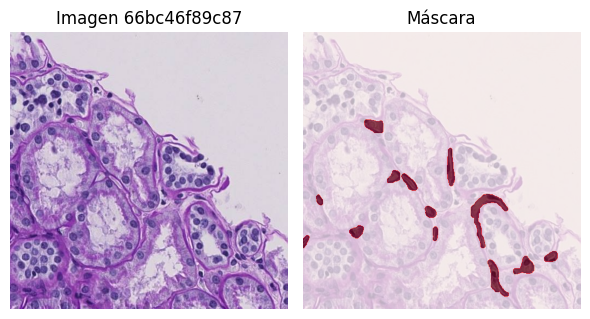

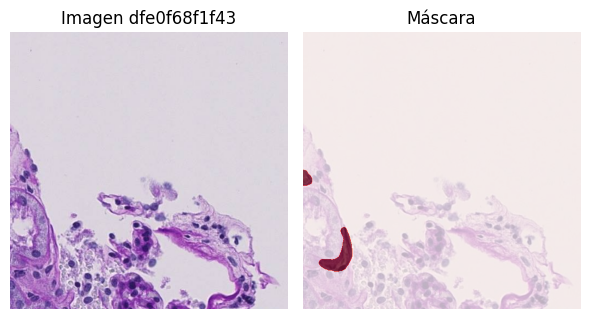

In [ ]:

def cargar_imagen(tile_id):
    return Image.open(f"train/{tile_id}.tif")

def generar_mascara(lista_poligonos):
    mask = np.zeros((512, 512), dtype=np.uint8)
    for poly in lista_poligonos:
        pts = np.array(poly, np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

def mostrar_ejemplo(tile_id):
    img = cargar_imagen(tile_id)
    sub = df_anot[df_anot['id'] == tile_id]
    mask_total = np.zeros((512, 512), dtype=np.uint8)
    for _, fila in sub.iterrows():
        mask_total |= generar_mascara(fila['coordinates'])
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[0].set_title(f'Imagen {tile_id}')
    ax[1].imshow(img)
    ax[1].imshow(mask_total, alpha=0.7, cmap='Reds')
    ax[1].set_title('Máscara')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()


muestras = random.sample(list(df_anot_agr['id']), min(9, len(meta_tiles)))

for tid in muestras:
    mostrar_ejemplo(tid)

### Parte B

In [ ]:
meta_tiles = pd.read_csv("tile_meta.csv")

with open("polygons.jsonl") as f:
    anotaciones = {json.loads(l)["id"]:json.loads(l)["annotations"] for l in f}

ids_anotados = [tid for tid in meta_tiles.id.tolist() if tid in anotaciones]
kfold = KFold(n_splits=2, shuffle=True, random_state=0)


In [ ]:
class HuBMAP(Dataset):
    def __init__(self, ids, aug=False, gris=False):
        self.ids = ids; self.aug = aug; self.gris = gris

    def __len__(self): return len(self.ids)

    def _mask(self, tid):
        if tid not in anotaciones:
            return np.zeros((512,512), np.uint8)
        m = np.zeros((512,512), np.uint8)
        for a in anotaciones[tid]:
            pts = np.array(a["coordinates"][0])
            rr, cc = polygon(pts[:,1], pts[:,0])
            if a["type"] == "blood_vessel":
                m[rr, cc] = 1
            elif a["type"] == "glomerulus":
                m[rr, cc] = 0
        return m

    def __getitem__(self, idx):
        tid = self.ids[idx]
        try:
            img_path = f"train/{tid}.tif"
            if not os.path.exists(img_path):
                raise FileNotFoundError(img_path)

            img = tiff.imread(img_path).astype(np.float32) / 255
            if img.ndim == 2:
                # img = np.repeat(img[..., None], 3, 2)
                img = img[..., None]

            elif self.gris:                         # convertir
                img = img.mean(2, keepdims=True)

            msk = self._mask(tid).astype(np.float32)

            if self.aug and random.random() > 0.5:
                img = np.flip(img, 1).copy()
                msk = np.flip(msk, 1).copy()

            img = torch.from_numpy(img).permute(2, 0, 1).contiguous()
            msk = torch.from_numpy(msk).unsqueeze(0).contiguous()
            return img, msk

        except Exception as e:
            print(f"Excepción en tile {tid}: {e}")
            raise


In [ ]:
def dice_loss(p,t):
    p=torch.sigmoid(p); p=p.view(-1); t=t.view(-1)
    inter=(p*t).sum(); return 1-(2*inter+1)/(p.sum()+t.sum()+1)


def entrenar_modelo(modelo, nombre, epocas=2, lote=4, gris=False):
    inicio = time.time()
    preds, truth = [], []
    for f, (tr, vl) in enumerate(kfold.split(ids_anotados)):
        print(f"Fold {f+1}")
        dl_tr = DataLoader(HuBMAP(np.array(ids_anotados)[tr], aug=True, gris=gris),
                           batch_size=lote, shuffle=True,
                           num_workers=0, pin_memory=True, drop_last=True)
        dl_vl = DataLoader(HuBMAP(np.array(ids_anotados)[vl], gris=gris),
                           batch_size=lote, shuffle=False,
                           num_workers=0, pin_memory=True)
        modelo.to(device)
        opt = optim.Adam(modelo.parameters(), 1e-3)
        for e in range(epocas):
            modelo.train(); ltr = []
            for x, y in dl_tr:
                x, y = x.to(device), y.to(device)
                opt.zero_grad()
                o = modelo(x)
                l = dice_loss(o, y)
                l.backward(); opt.step()
                ltr.append(l.item())
            print(f"Época {e+1} pérdida {np.mean(ltr):.4f}")
        modelo.eval(); pl = []
        with torch.no_grad():
            for x, y in dl_vl:
                x = x.to(device)
                o = torch.sigmoid(modelo(x)).cpu().numpy()
                pl.append(o); truth.append(y.numpy())
        preds.append(np.concatenate(pl,0))
        gc.collect(); torch.cuda.empty_cache()
    np.savez(f"{nombre}_pred.npz", p=np.concatenate(preds,0),
                                     t=np.concatenate(truth,0))
    print(f"Tiempo total {time.time()-inicio:.1f}s")


In [ ]:
def calcular_metricas(ruta):
    d = np.load(ruta)
    p = d["p"]                      # probabilidades (float32)
    t = d["t"]                      # ground‑truth (float32)

    # binarizamos
    pb = (p >= 0.5).astype(np.uint8)
    gt = (t >= 0.5).astype(np.uint8)

    # planos 1‑D para métricas escalar‑escalares
    pb_flat = pb.reshape(-1)
    gt_flat = gt.reshape(-1)

    inter = (pb & gt).sum()
    union = (pb | gt).sum()

    dice = 2 * inter / (pb.sum() + gt.sum() + 1e-7)
    iou  = inter / (union + 1e-7)
    prec = precision_score(gt_flat, pb_flat, zero_division=0)
    rec  = recall_score(gt_flat, pb_flat, zero_division=0)
    auc  = roc_auc_score(gt_flat, p.reshape(-1))

    # Hausdorff medio (ignora pares vacíos)
    hds = []
    for i in range(len(pb)):
        a, b = pb[i,0], gt[i,0]
        if a.sum() and b.sum():
            hds.append(hd95(a, b))
    hd = np.mean(hds) if hds else 0

    bal = balanced_accuracy_score(gt_flat, pb_flat)

    return dice, iou, prec, rec, auc, hd, bal



In [ ]:
resultados={}

In [ ]:
# unet = smp.Unet("resnet18", classes=1, encoder_weights=None, in_channels=3)
# entrenar_modelo(unet, "unet")

Fold 1

Época 1 pérdida 0.7357

Época 2 pérdida 0.5802

Fold 2

Época 1 pérdida 0.5490

Época 2 pérdida 0.5209

Tiempo total 2960.1s

In [ ]:
# resultados["U-Net"]=calcular_metricas("unet_pred.npz")
# print(resultados["U-Net"])


In [ ]:
resultados["U-Net"] = (0.3657676171209982, 0.223816160390012, 0.5818459552217784, 0.2667175449525134, 0.6976392639819838, 214.9718765130667, 0.6288454613023772)

In [ ]:
# vnet = monai.networks.nets.VNet(
#     spatial_dims=2,    # 2‑D porque los tiles son 512×512
#     in_channels=1,
#     out_channels=1,
#     act="relu"
# )
# entrenar_modelo(vnet,"vnet")


Fold 1

Época 1 pérdida 0.9191

Época 2 pérdida 0.9154

Fold 2

Época 1 pérdida 0.9092

Época 2 pérdida 0.9039

Tiempo total 5797.5s

In [ ]:
# resultados["V_Net"]=calcular_metricas("vnet_pred.npz")
# print(resultados["V_Net"])


In [ ]:
resultados["V_Net"] = (0.12536624099297586, 0.06687505780296049, 0.07091400658766504, 0.5400525739978579, 0.6305296480084055, 206.19146433752485, 0.6034261555389702)

In [ ]:
# class SegNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder=nn.Sequential(
#             nn.Conv2d(3,32,3,1,1),nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(2),
#             nn.Conv2d(32,64,3,1,1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2))
#         self.decoder=nn.Sequential(
#             nn.ConvTranspose2d(64,32,2,2),nn.BatchNorm2d(32),nn.ReLU(),
#             nn.ConvTranspose2d(32,1,2,2))
#     def forward(self,x): return self.decoder(self.encoder(x))

# segnet=SegNet()
# entrenar_modelo(segnet,"segnet")


Fold 1

Época 1 pérdida 0.8839

Época 2 pérdida 0.8024

Fold 2

Época 1 pérdida 0.7536

Época 2 pérdida 0.7436

Tiempo total 973.7s

In [ ]:
# resultados["SegNet"]=calcular_metricas("segnet_pred.npz")
# print(resultados["SegNet"])

In [ ]:
resultados["SegNet"] = (0.22675554542990525, 0.12787607757379385, 0.2369690363294747, 0.21738608988773034, 0.6405428333526553, 179.0008254925285, 0.5922115075397454)

In [ ]:
# deeplab=smp.DeepLabV3Plus("resnet34",classes=1,encoder_weights=None,in_channels=3)
# entrenar_modelo(deeplab,"deeplab")

Fold 1

Época 1 pérdida 0.7330

Época 2 pérdida 0.5968

Fold 2

Época 1 pérdida 0.5733

Época 2 pérdida 0.5476

Tiempo total 3653.1s

In [ ]:
# resultados["DeepLabV3+"]=calcular_metricas("deeplab_pred.npz")
# print(resultados["DeepLabV3+"])

In [ ]:
resultados["DeepLabV3+"] = (0.14195539539967134, 0.07640042389090353, 0.08360187760641055, 0.4700399423804192, 0.6695391203753587, 182.82947204832968, 0.6137039010102096)

In [ ]:
# att_unet=smp.Unet("resnet18",classes=1,encoder_weights=None,in_channels=3,decoder_attention_type="scse")
# entrenar_modelo(att_unet,"attention_unet")


Fold 1

Época 1 pérdida 0.6994

Época 2 pérdida 0.5708

Fold 2

Época 1 pérdida 0.5381

Época 2 pérdida 0.5229

Tiempo total 3646.5s

In [ ]:
# resultados["Attention U-Net"]=calcular_metricas("attention_unet_pred.npz")
# print(resultados["Attention U-Net"])


In [ ]:
resultados["Attention U-Net"] = (0.4190511078853865, 0.26506303269859705, 0.606627315675494, 0.320078973709521, 0.6933218467927132, 169.42644471092657, 0.6551523467114649)

In [ ]:
# from skimage.measure import label, regionprops


# def colar(batch):
#     imgs, tgts, gts = zip(*batch)
#     return list(imgs), list(tgts), list(gts)


# class HuBMAPMaskRCNN(Dataset):
#     def __init__(self, ids, aug=False):
#         self.base = HuBMAP(ids, aug=aug, gris=False)

#     def __len__(self): return len(self.base)

#     def __getitem__(self, idx):
#         img, sem = self.base[idx]            # sem = (1,512,512) uint8
#         m = sem.squeeze(0).numpy()
#         inst = label(m, connectivity=1)
#         props = regionprops(inst)

#         if len(props)==0:                    # tile sin vasos
#             target = {
#                 "boxes":  torch.zeros((0,4), dtype=torch.float32),
#                 "labels": torch.zeros((0,),  dtype=torch.int64),
#                 "masks":  torch.zeros((0,512,512), dtype=torch.uint8),
#                 "image_id": torch.tensor([idx]),
#                 "area":    torch.zeros((0,),  dtype=torch.float32),
#                 "iscrowd": torch.zeros((0,),  dtype=torch.int64),
#             }
#             return img, target, sem

#         boxes, masks = [], []
#         for p in props:
#             y1,x1,y2,x2 = p.bbox
#             boxes.append([x1,y1,x2,y2])
#             masks.append((inst==p.label).astype(np.uint8))

#         target = {
#             "boxes":  torch.as_tensor(boxes, dtype=torch.float32),
#             "labels": torch.ones((len(boxes),), dtype=torch.int64),
#             "masks":  torch.as_tensor(masks, dtype=torch.uint8),
#             "image_id": torch.tensor([idx]),
#             "area":   torch.as_tensor([(b[2]-b[0])*(b[3]-b[1]) for b in boxes], dtype=torch.float32),
#             "iscrowd":torch.zeros((len(boxes),), dtype=torch.int64),
#         }
#         return img, target, sem


# def entrenar_maskrcnn(modelo, nombre, epocas=2, lote=2):
#     inicio=time.time(); preds, truth = [], []
#     for f,(tr,vl) in enumerate(kfold.split(ids_anotados)):
#         print(f"[Mask] Fold {f+1}")
#         dl_tr = DataLoader(
#             HuBMAPMaskRCNN(np.array(ids_anotados)[tr], aug=True),
#             batch_size=lote, shuffle=True, num_workers=0,
#             pin_memory=True, drop_last=True, collate_fn=colar
#         )
#         dl_vl = DataLoader(
#             HuBMAPMaskRCNN(np.array(ids_anotados)[vl]),
#             batch_size=1, shuffle=False, num_workers=0,
#             pin_memory=True, collate_fn=colar
#         )

#         modelo.to(device).train()
#         opt = optim.Adam(modelo.parameters(), 1e-4)

#         for e in range(epocas):
#             ltr=[]
#             for imgs, tgts, _ in dl_tr:
#                 imgs = [i.to(device) for i in imgs]
#                 tgts = [{k:(v.to(device) if torch.is_tensor(v) else v)
#                          for k,v in t.items()} for t in tgts]
#                 loss = sum(modelo(imgs, tgts).values())
#                 opt.zero_grad(); loss.backward(); opt.step()
#                 ltr.append(loss.item())
#             print(f"  Época {e+1} pérdida {np.mean(ltr):.4f}")

#         modelo.eval(); pl=[]
#         with torch.no_grad():
#             for imgs, _, gts in dl_vl:
#                 out = modelo([imgs[0].to(device)])[0]
#                 mpred = torch.zeros_like(gts[0][0])
#                 keep = out["scores"] > 0.3
#                 for m in out["masks"][keep]:
#                     mpred = torch.maximum(mpred, (m[0]>0.5).cpu().to(torch.uint8))
#                 pl.append(mpred.numpy()); truth.append(gts[0].numpy())
#         preds.append(np.stack(pl,0))
#         gc.collect(); torch.cuda.empty_cache()

#     np.savez(f"{nombre}_pred.npz", p=np.concatenate(preds,0),
#                                  t=np.concatenate(truth,0))
#     print(f"Tiempo total {time.time()-inicio:.1f}s")



# maskrcnn = maskrcnn_resnet50_fpn(weights=None, num_classes=2)
# entrenar_maskrcnn(maskrcnn, "maskrcnn")


Época 1 pérdida 1.4263

Época 2 pérdida 1.2548

[Mask] Fold 2

Época 1 pérdida 1.1962

Época 2 pérdida 1.1006

Tiempo total 21688.6s

In [ ]:
# resultados["Mask R-CNN"]=calcular_metricas("maskrcnn_pred.npz")
# print(resultados["Mask R-CNN"])


In [ ]:
resultados["Mask R-CNN"] = (0.4700875588981105, 0.30726435465779933, 0.35290892473696067, 0.7037623147102636, 0.8214972106265819, 141.30209424083768, 0.8214972106265819)

In [ ]:
# resunet=smp.Unet("resnet18",classes=1,encoder_weights=None,in_channels=3)
# entrenar_modelo(resunet,"resunet")


Fold 1

Época 1 pérdida 0.7333

Época 2 pérdida 0.5781

Fold 2

Época 1 pérdida 0.5626

Época 2 pérdida 0.5336

Tiempo total 2984.7s

In [ ]:
# resultados["ResUNet"]=calcular_metricas("resunet_pred.npz")
# print(resultados["ResUNet"])


In [ ]:
resultados["ResUNet"] = (0.21392137692719543, 0.11977153422236302, 0.5997590162502497, 0.13017624791565846, 0.5722688012534252, 229.33932011038922, 0.5630426595288168)

In [ ]:
# psp=smp.PSPNet("mobilenet_v2",classes=1,encoder_weights=None,in_channels=3)
# entrenar_modelo(psp,"pspnet")


Fold 1

Época 1 pérdida 0.6465

Época 2 pérdida 0.5530

Fold 2

Época 1 pérdida 0.5336

Época 2 pérdida 0.5074

Tiempo total 993.4s

In [ ]:
# resultados["PSPNet"]=calcular_metricas("pspnet_pred.npz")
# print(resultados["PSPNet"])


In [ ]:
resultados["PSPNet"] = (0.4400795696195428, 0.28211667790786576, 0.3947327118913157, 0.4971975822547149, 0.8499361504748153, 175.85728472086944, 0.7306477970888254)

In [ ]:
# fcn=smp.FPN("mobilenet_v2",classes=1,encoder_weights=None,in_channels=3)
# entrenar_modelo(fcn,"fcn")


Fold 1

Época 1 pérdida 0.7297

Época 2 pérdida 0.6134

Fold 2

Época 1 pérdida 0.5754

Época 2 pérdida 0.5436

Tiempo total 2075.8s

In [ ]:
# resultados["FCN"]=calcular_metricas("fcn_pred.npz")
# print(resultados["FCN"])


In [ ]:
resultados["FCN"] = (0.4126242842557098, 0.2599411595900837, 0.5080749616815667, 0.3473656359026521, 0.7714862508142828, 192.9422429572784, 0.6657637622551611)

In [ ]:


# from monai.networks.nets import SwinUNETR

# swin_unet = SwinUNETR(
#     img_size=(512,512),
#     in_channels=3,
#     out_channels=1,
#     spatial_dims=2,          # ← 2‑D tiles
#     feature_size=24          # modelo pequeño y rápido
# )

# entrenar_modelo(swin_unet,"swin_unet")


Fold 1

Época 1 pérdida 0.8214

Época 2 pérdida 0.6322

Fold 2

Época 1 pérdida 0.5621

Época 2 pérdida 0.5310

Tiempo total 5929.9s

In [ ]:
# resultados["Swin U-Net"]=calcular_metricas("swin_unet_pred.npz")
# print(resultados["Swin U-Net"])


In [ ]:
resultados["Swin U-Net"] = (0.474761716926587, 0.3112705222491033, 0.4875930075492259, 0.4625884359955025, 0.7592380966148162, 155.10278622208094, 0.7198478485162607)

In [ ]:
cols=["Dice","IoU","Precisión","Recall","AUC","Hausdorff","Balanced Acc."]

tabla_resultados_modelos=pd.DataFrame(resultados,index=cols).T
tabla_resultados_modelos

Dice       IoU  Precisión    Recall       AUC  \
U-Net            0.365768  0.223816   0.581846  0.266718  0.697639   
V_Net            0.125366  0.066875   0.070914  0.540053  0.630530   
SegNet           0.226756  0.127876   0.236969  0.217386  0.640543   
DeepLabV3+       0.141955  0.076400   0.083602  0.470040  0.669539   
Attention U-Net  0.419051  0.265063   0.606627  0.320079  0.693322   
Mask R-CNN       0.470088  0.307264   0.352909  0.703762  0.821497   
ResUNet          0.213921  0.119772   0.599759  0.130176  0.572269   
PSPNet           0.440080  0.282117   0.394733  0.497198  0.849936   
FCN              0.412624  0.259941   0.508075  0.347366  0.771486   
Swin U-Net       0.474762  0.311271   0.487593  0.462588  0.759238   

                  Hausdorff  Balanced Acc.  
U-Net            214.971877       0.628845  
V_Net            206.191464       0.603426  
SegNet           179.000825       0.592212  
DeepLabV3+       182.829472       0.613704  
Attention U-Net  169.426445       0.655152  
Mask R-CNN       141.302094       0.821497  
ResUNet          229.339320       0.563043  
PSPNet           175.857285       0.730648  
FCN              192.942243       0.665764  
Swin U-Net       155.102786       0.719848

In [ ]:
print(tabla_resultados_modelos.to_markdown())

|                 |     Dice |       IoU |   Precisión |   Recall |      AUC |   Hausdorff |   Balanced Acc. |
|:----------------|---------:|----------:|------------:|---------:|---------:|------------:|----------------:|
| U-Net           | 0.365768 | 0.223816  |   0.581846  | 0.266718 | 0.697639 |     214.972 |        0.628845 |
| V_Net           | 0.125366 | 0.0668751 |   0.070914  | 0.540053 | 0.63053  |     206.191 |        0.603426 |
| SegNet          | 0.226756 | 0.127876  |   0.236969  | 0.217386 | 0.640543 |     179.001 |        0.592212 |
| DeepLabV3+      | 0.141955 | 0.0764004 |   0.0836019 | 0.47004  | 0.669539 |     182.829 |        0.613704 |
| Attention U-Net | 0.419051 | 0.265063  |   0.606627  | 0.320079 | 0.693322 |     169.426 |        0.655152 |
| Mask R-CNN      | 0.470088 | 0.307264  |   0.352909  | 0.703762 | 0.821497 |     141.302 |        0.821497 |
| ResUNet         | 0.213921 | 0.119772  |   0.599759  | 0.130176 | 0.572269 |     229.339 |        0.563043 |
|

|                 |     Dice |       IoU |   Precisión |   Recall |      AUC |   Hausdorff |   Balanced Acc. |
|:----------------|---------:|----------:|------------:|---------:|---------:|------------:|----------------:|
| U-Net           | 0.365768 | 0.223816  |   0.581846  | 0.266718 | 0.697639 |     214.972 |        0.628845 |
| V_Net           | 0.125366 | 0.0668751 |   0.070914  | 0.540053 | 0.63053  |     206.191 |        0.603426 |
| SegNet          | 0.226756 | 0.127876  |   0.236969  | 0.217386 | 0.640543 |     179.001 |        0.592212 |
| DeepLabV3+      | 0.141955 | 0.0764004 |   0.0836019 | 0.47004  | 0.669539 |     182.829 |        0.613704 |
| Attention U-Net | 0.419051 | 0.265063  |   0.606627  | 0.320079 | 0.693322 |     169.426 |        0.655152 |
| Mask R-CNN      | 0.470088 | 0.307264  |   0.352909  | 0.703762 | 0.821497 |     141.302 |        0.821497 |
| ResUNet         | 0.213921 | 0.119772  |   0.599759  | 0.130176 | 0.572269 |     229.339 |        0.563043 |
| PSPNet          | 0.44008  | 0.282117  |   0.394733  | 0.497198 | 0.849936 |     175.857 |        0.730648 |
| FCN             | 0.412624 | 0.259941  |   0.508075  | 0.347366 | 0.771486 |     192.942 |        0.665764 |
| Swin U-Net      | 0.474762 | 0.311271  |   0.487593  | 0.462588 | 0.759238 |     155.103 |        0.719848 |


- **Dice Coefficient (Coeficiente de Dice)**

Fórmula:

$$
Dice = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

Qué mide: Similitud entre el área predicha y la verdadera.

Interpretación:  

`0.0`: sin superposición  

`1.0`: superposición perfecta


- **IoU (Intersection over Union)**

Fórmula:  

$$
IoU = \frac{TP}{TP + FP + FN}
$$

También conocido como: Jaccard Index.

Comparación: Similar a Dice, pero más estricto.


- **Precisión (Precision)**

Fórmula:  

$$
Precision = \frac{TP}{TP + FP}
$$

Qué mide: De las regiones predichas como positivas, ¿cuántas lo eran realmente?

Alta precisión: pocos falsos positivos.



- **Recall (Sensibilidad o Exhaustividad)**

Fórmula:  

$$
Recall = \frac{TP}{TP + FN}
$$

Qué mide: De los verdaderos vasos, ¿cuántos fueron detectados?

Alta sensibilidad: pocos falsos negativos.



- **AUC (Área Bajo la Curva ROC)**

Qué mide: Capacidad del modelo para distinguir entre clases (vaso vs no vaso).

Valores típicos:

`0.5`: predicción aleatoria

`1.0`: separación perfecta

Útil cuando el modelo entrega probabilidades.



- **Hausdorff Distance**

Qué mide: Qué tan lejos están los bordes predichos respecto a los reales.

Valor bajo = mejor.

Importante: en tareas médicas donde los bordes son clínicamente relevantes.



- **Balanced Accuracy (Precisión Balanceada)**

Fórmula:  

$$
\text{BAcc} = \frac{Recall_{class1} + Recall_{class0}}{2}
$$

Funcion: Manejar el desbalance de clases (por ejemplo, mucho fondo y pocos vasos).


- Interpretación general

| Métrica         | Evalúa principalmente...               |
|-----------------|----------------------------------------|
| Dice / IoU      | Superposición entre predicción y verdad |
| Precisión       | Ausencia de falsos positivos           |
| Recall          | Ausencia de falsos negativos           |
| AUC             | Separabilidad general entre clases     |
| Hausdorff       | Precisión en los bordes                |
| Balanced Acc.   | Desempeño equilibrado en clases        |



Entre los modelos evaluados, `Mask R-CNN` y `Swin U-Net` presentan los mejores desempeños globales. `Mask R-CNN` logra un equilibrio notable entre las métricas, obteniendo la mayor puntuación en Sensibilidad (0.70), la menor Distancia de Hausdorff (141.30) y la mayor Precisión Balanceada (0.82). `Swin U-Net`, por su parte, presenta el mayor Coeficiente Dice (0.47) y la mayor IoU (0.31), además de una precisión y sensibilidad competitivas. Esto indica que ambos modelos son capaces de segmentar con precisión y coherencia espacial los vasos sanguíneos, incluso en condiciones computacionales restringidas.

El modelo `PSPNet` también se destaca, particularmente en el área bajo la curva ROC (0.85) y una buena sensibilidad, lo que lo convierte en una opción viable cuando se busca maximizar la detección sin importar tanto la precisión de las fronteras. Por otro lado, modelos como V-Net y DeepLabV3+ muestran desempeños significativamente inferiores en la mayoría de métricas. En estos casos, las puntuaciones bajas de Dice e IoU, combinadas con una precisión reducida, indican dificultades para adaptarse a la estructura del problema y a la escala de entrada de los tiles.

`U-Net`, `Attention U-Net`, `FCN` y `SegNet` muestran desempeños intermedios, siendo opciones aceptables dependiendo del contexto específico, aunque en términos generales fueron superados por las variantes más recientes.

### Parte C

#### Boxplots

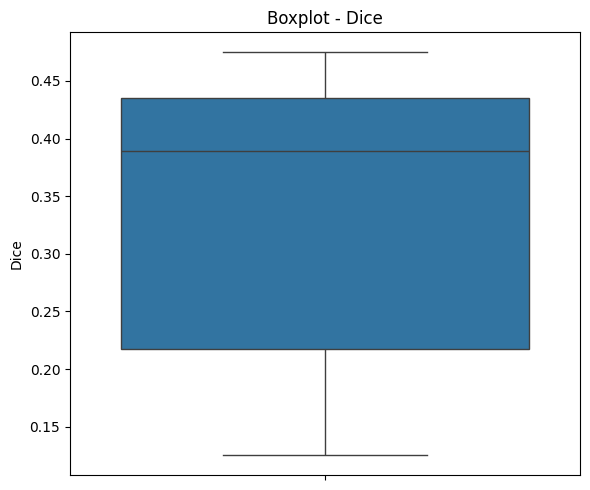

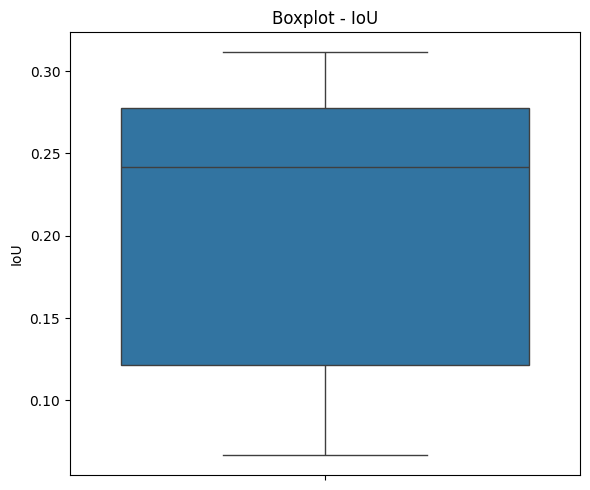

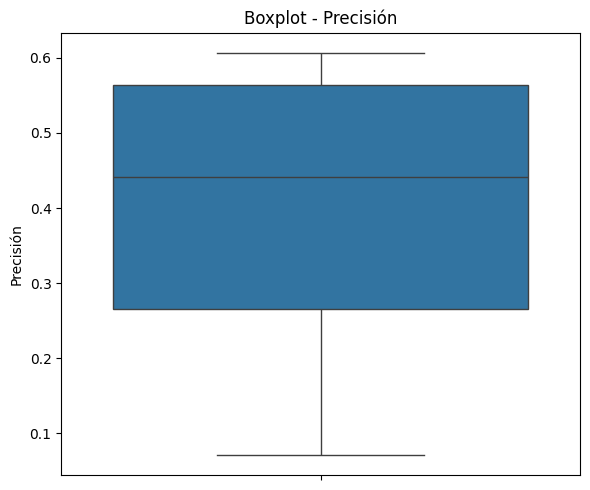

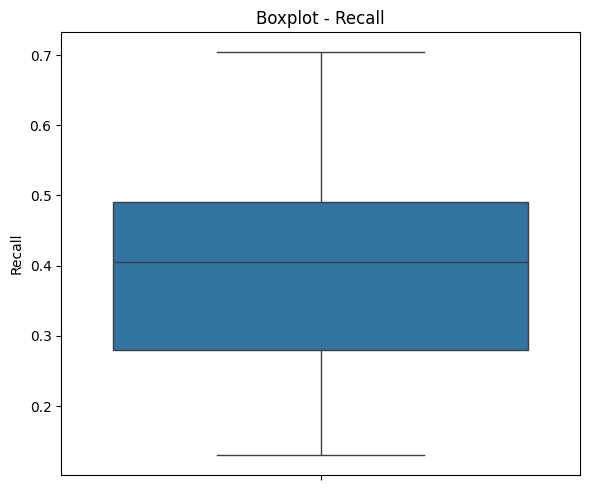

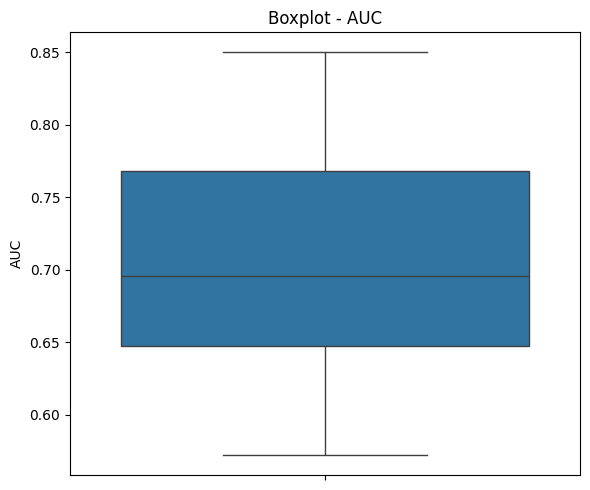

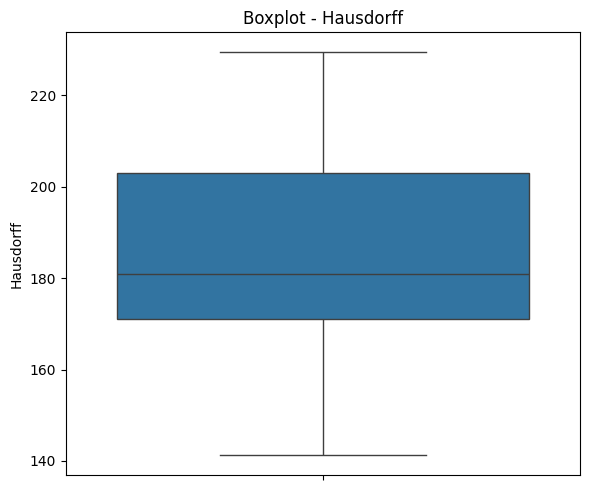

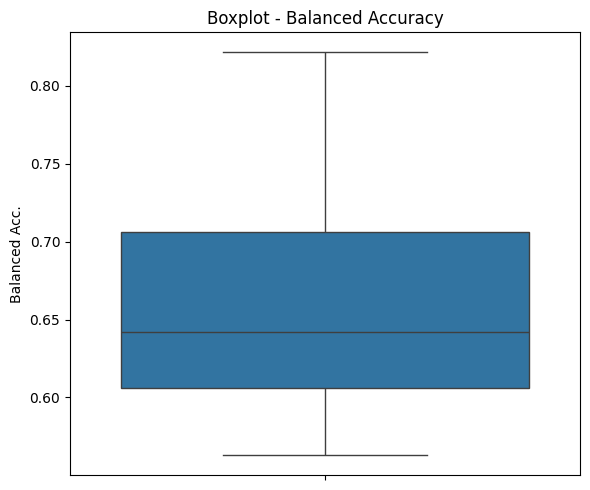

In [ ]:


# Boxplot para Dice
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["Dice"])
plt.title("Boxplot - Dice")
plt.tight_layout()
plt.show()


# Boxplot para IoU
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["IoU"])
plt.title("Boxplot - IoU")
plt.tight_layout()
plt.show()


# Boxplot para Precisión
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["Precisión"])
plt.title("Boxplot - Precisión")
plt.tight_layout()
plt.show()


# Boxplot para Recall
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["Recall"])
plt.title("Boxplot - Recall")
plt.tight_layout()
plt.show()


# Boxplot para AUC
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["AUC"])
plt.title("Boxplot - AUC")
plt.tight_layout()
plt.show()


# Boxplot para Hausdorff
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["Hausdorff"])
plt.title("Boxplot - Hausdorff")
plt.tight_layout()
plt.show()


# Boxplot para Balanced Accuracy
plt.figure(figsize=(6, 5))
sns.boxplot(y=tabla_resultados_modelos["Balanced Acc."])
plt.title("Boxplot - Balanced Accuracy")
plt.tight_layout()
plt.show()



1. Coeficiente Dice

El boxplot de Dice muestra una distribución relativamente amplia con valores entre aproximadamente 0.12 y 0.47, y una mediana cercana a 0.39.
Esto indica que aunque algunos modelos logran segmentaciones relativamente precisas (por encima de 0.45), hay otros cuya capacidad de superposición entre predicción y verdad de terreno es bastante limitada. La dispersión sugiere diferencias marcadas en el rendimiento de los modelos.

2. IoU (Intersección sobre la Unión)

La distribución de IoU sigue una tendencia similar a la del Dice, aunque con valores naturalmente más bajos (dado que IoU es una métrica más estricta).
El rango va desde aproximadamente 0.07 hasta 0.31, con una mediana cercana a 0.24.
El hecho de que existan valores tan bajos sugiere que algunos modelos están teniendo dificultades para cubrir adecuadamente las regiones de interés.

3. Precisión

El boxplot de Precisión muestra una dispersión considerable, con valores que oscilan entre 0.07 y 0.61, y una mediana cercana a 0.45.
Esto indica que si bien algunos modelos son muy conservadores y predicen pocas regiones (generando alta precisión), otros pueden tener un mayor número de falsos positivos. La variabilidad también puede deberse a diferencias en las estrategias de regularización o umbral de predicción.

4. Recall (Sensibilidad)

El Recall presenta un comportamiento opuesto al de la Precisión, con un rango de 0.13 a 0.70 y una mediana de aproximadamente 0.41.
Esto sugiere que mientras algunos modelos tienden a cubrir la mayoría de las regiones relevantes (con mayor recall), lo hacen a expensas de una menor precisión. La dispersión alta también indica un posible desbalance en el aprendizaje de los modelos frente a clases poco representadas.

5. AUC (Área bajo la curva ROC)

La AUC muestra valores más concentrados entre 0.57 y 0.85, con una mediana cercana a 0.70.
Esto indica un desempeño general aceptable en términos de discriminación entre clases, aunque también refleja que no todos los modelos manejan bien el trade-off entre sensibilidad y especificidad. Es una métrica más global, menos influenciada por umbrales individuales.

6. Distancia de Hausdorff

La métrica Hausdorff presenta una dispersión muy marcada, con valores entre 140 y 230 aproximadamente.
Al tratarse de una métrica sensible a errores puntuales en los bordes, los valores altos indican modelos que cometen errores más severos en la localización o en la forma de las regiones segmentadas. La mediana parece rondar los 180, lo cual es alto en contextos médicos, y sugiere margen importante de mejora en la fidelidad geométrica.

7. Precisión Balanceada

La Precisión Balanceada, que considera tanto la sensibilidad como la especificidad, muestra una distribución entre 0.56 y 0.82, con una mediana cercana a 0.65.
Esta métrica es particularmente útil en contextos con clases desbalanceadas como en segmentación médica. Su dispersión relativamente baja, en comparación con otras métricas, indica que la mayoría de los modelos alcanzan un rendimiento razonablemente equilibrado entre las clases.

#### Histogramas

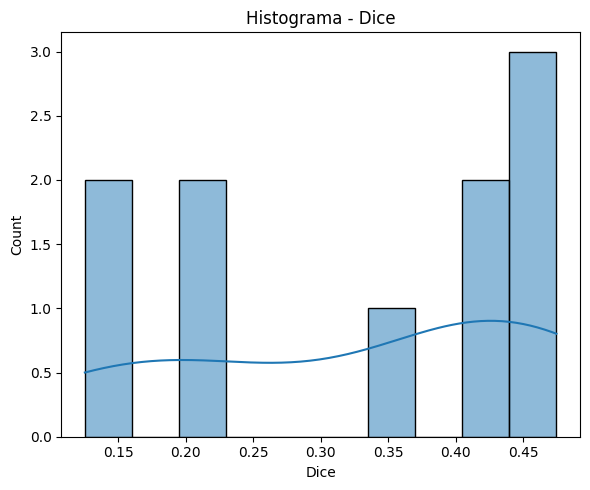

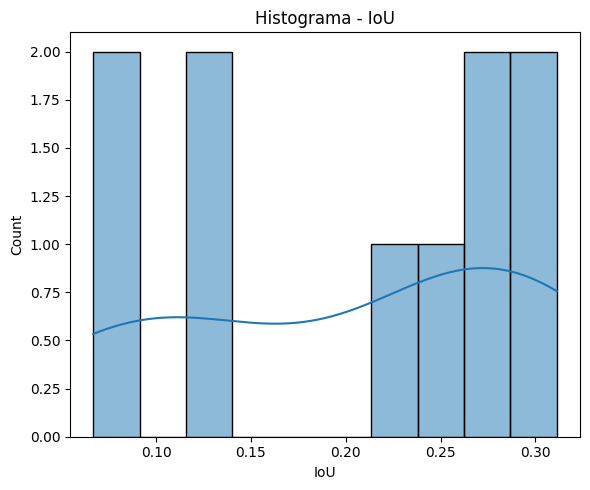

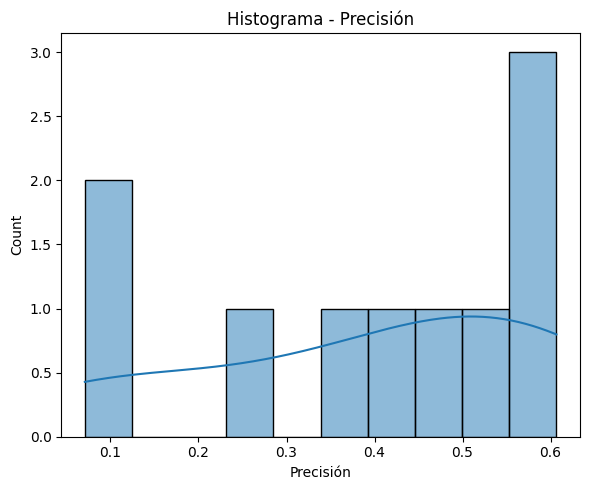

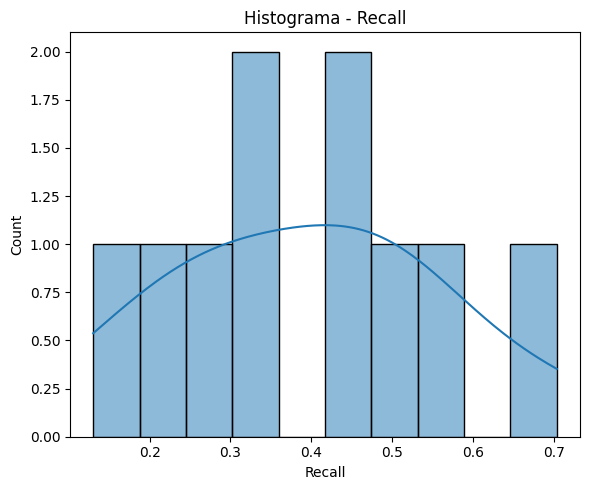

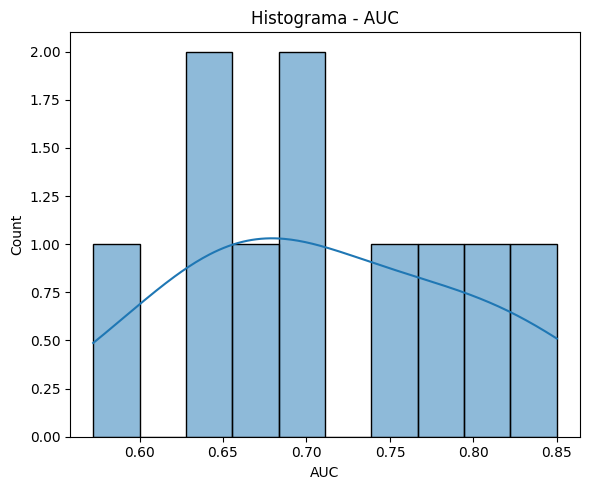

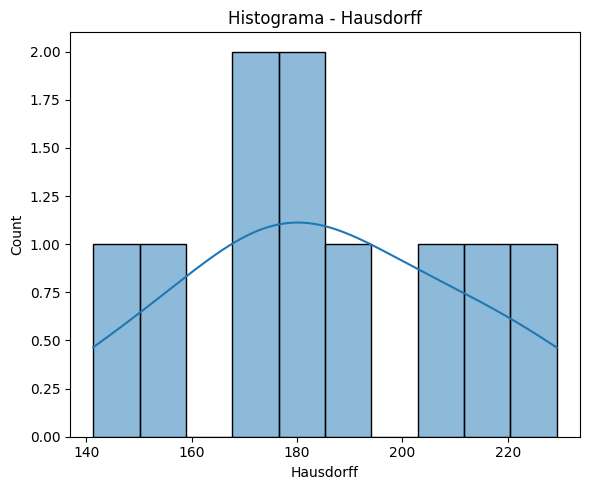

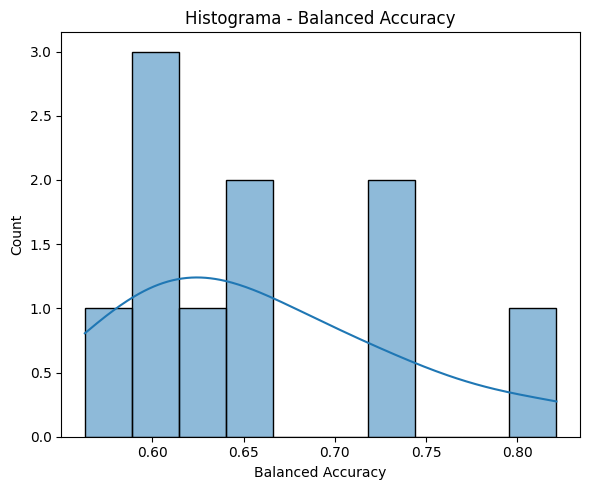

In [ ]:
# Histograma para Dice
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["Dice"], kde=True, bins=10)
plt.title("Histograma - Dice")
plt.xlabel("Dice")
plt.tight_layout()
plt.show()

# Histograma para IoU
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["IoU"], kde=True, bins=10)
plt.title("Histograma - IoU")
plt.xlabel("IoU")
plt.tight_layout()
plt.show()

# Histograma para Precisión
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["Precisión"], kde=True, bins=10)
plt.title("Histograma - Precisión")
plt.xlabel("Precisión")
plt.tight_layout()
plt.show()

# Histograma para Recall
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["Recall"], kde=True, bins=10)
plt.title("Histograma - Recall")
plt.xlabel("Recall")
plt.tight_layout()
plt.show()

# Histograma para AUC
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["AUC"], kde=True, bins=10)
plt.title("Histograma - AUC")
plt.xlabel("AUC")
plt.tight_layout()
plt.show()

# Histograma para Hausdorff
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["Hausdorff"], kde=True, bins=10)
plt.title("Histograma - Hausdorff")
plt.xlabel("Hausdorff")
plt.tight_layout()
plt.show()

# Histograma para Balanced Accuracy
plt.figure(figsize=(6, 5))
sns.histplot(tabla_resultados_modelos["Balanced Acc."], kde=True, bins=10)
plt.title("Histograma - Balanced Accuracy")
plt.xlabel("Balanced Accuracy")
plt.tight_layout()
plt.show()


**Análisis de Distribución**

- Dice e IoU: Presentan distribuciones bimodales con acumulaciones en los rangos más bajos (por debajo de 0.25) y en valores altos (superiores a 0.40). Esto refuerza la idea de que algunos modelos tienen dificultades significativas, mientras otros alcanzan buenos desempeños.

- Precisión: Muestra una distribución sesgada a la derecha, con valores agrupados cerca de 0.6. Esto sugiere que varios modelos son conservadores al momento de predecir regiones, favoreciendo precisión sobre recall.

- Recall: Tiene una distribución más uniforme, lo cual indica mayor diversidad en la capacidad de los modelos para identificar todos los píxeles positivos. Algunos modelos presentan un comportamiento mucho más sensible.

- AUC: Su distribución se centra entre 0.65 y 0.85, lo cual indica que los modelos, en promedio, logran un desempeño aceptable en cuanto a discriminación entre clases.

- Hausdorff: Tiene una distribución relativamente simétrica, con una leve tendencia hacia valores más altos. Esto sugiere que algunos modelos cometen errores notables en la ubicación precisa de las fronteras.

- Balanced Accuracy: La mayoría de los modelos se agrupan entre 0.60 y 0.75, lo cual indica un comportamiento relativamente estable y equilibrado en cuanto a la predicción de ambas clases.

#### Comparacion Visual de Imagenes

In [ ]:
data = np.load("unet_pred.npz")
preds = data["p"]       # probabilidades (float32)
truth = data["t"]       # ground-truth

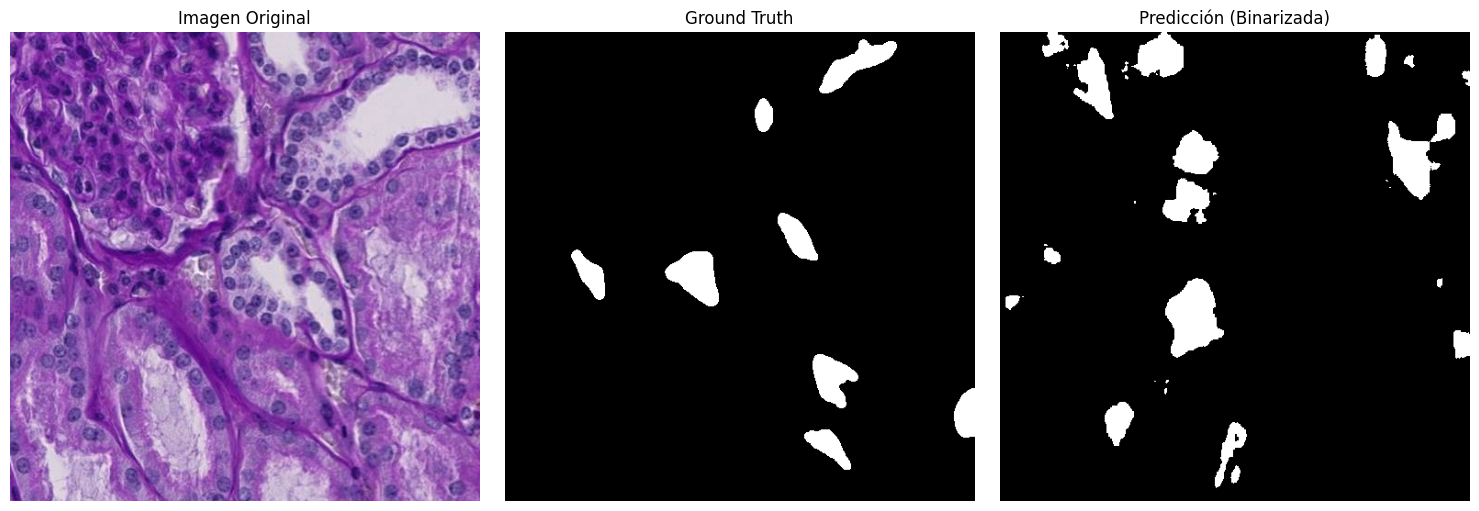

In [ ]:
import matplotlib.pyplot as plt
import tifffile as tiff

def mostrar_comparacion(tid, img_folder="train", ruta_npz="unet_pred.npz", indice=0):
    # Cargar imagen original
    img_path = os.path.join(img_folder, f"{tid}.tif")
    img = tiff.imread(img_path).astype(np.float32) / 255.0

    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)  # convertir a RGB

    # Ground Truth
    gt = HuBMAP([])._mask(tid)

    # Cargar predicción del modelo
    data = np.load(ruta_npz)
    pred_prob = data["p"][indice, 0]   # [512,512]
    pred_bin = (pred_prob >= 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Imagen Original")
    axes[1].imshow(gt, cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[2].imshow(pred_bin, cmap="gray")
    axes[2].set_title("Predicción (Binarizada)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


mostrar_comparacion("0006ff2aa7cd", ruta_npz="swin_unet_pred.npz", indice=0)

#### Curvas ROC y Precision-Recall

- Curva ROC (Receiver Operating Characteristic): mide la capacidad del modelo para distinguir entre clases. Un AUC cercano a 1 indica un modelo muy discriminativo, mientras que un valor cercano a 0.5 indica un comportamiento aleatorio.

- Curva Precision-Recall: evalúa el balance entre precisión y sensibilidad, especialmente útil cuando las clases están desbalanceadas (como en segmentación médica). Una buena curva PR se caracteriza por una área grande, especialmente cuando la clase positiva es escasa.

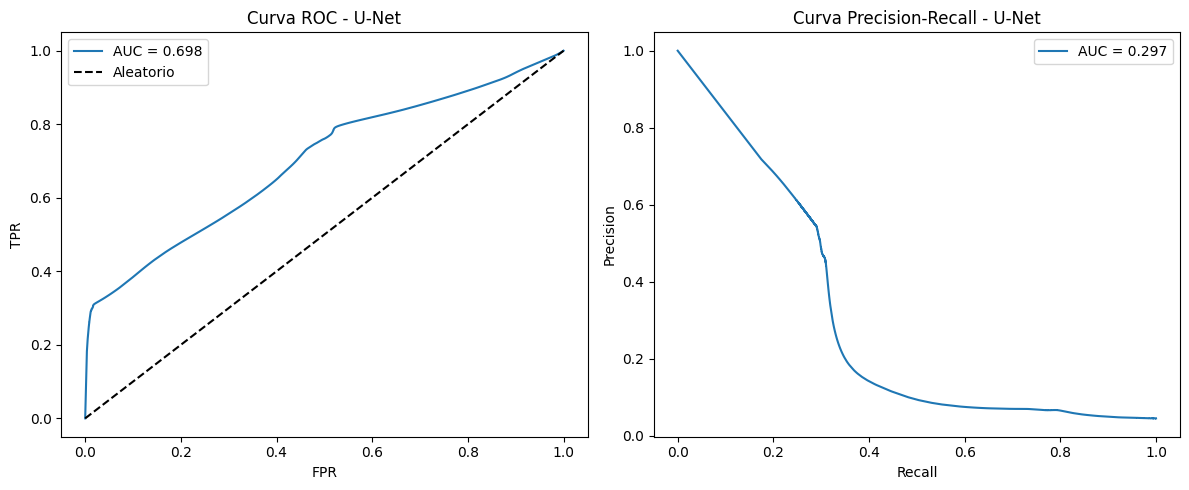

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def mostrar_curvas_roc_pr(ruta_npz, nombre_modelo="Modelo"):
    data = np.load(ruta_npz)
    p = data["p"].reshape(-1)   # predicciones como probabilidades (float)
    t = data["t"].reshape(-1)   # ground truth binarizado

    # ROC Curve
    fpr, tpr, _ = roc_curve(t, p)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(t, p)
    pr_auc = auc(recall, precision)

    # Graficar
    plt.figure(figsize=(12, 5))

    # Curva ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
    plt.title(f"Curva ROC - {nombre_modelo}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()

    # Curva PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
    plt.title(f"Curva Precision-Recall - {nombre_modelo}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()


mostrar_curvas_roc_pr("unet_pred.npz", "U-Net")

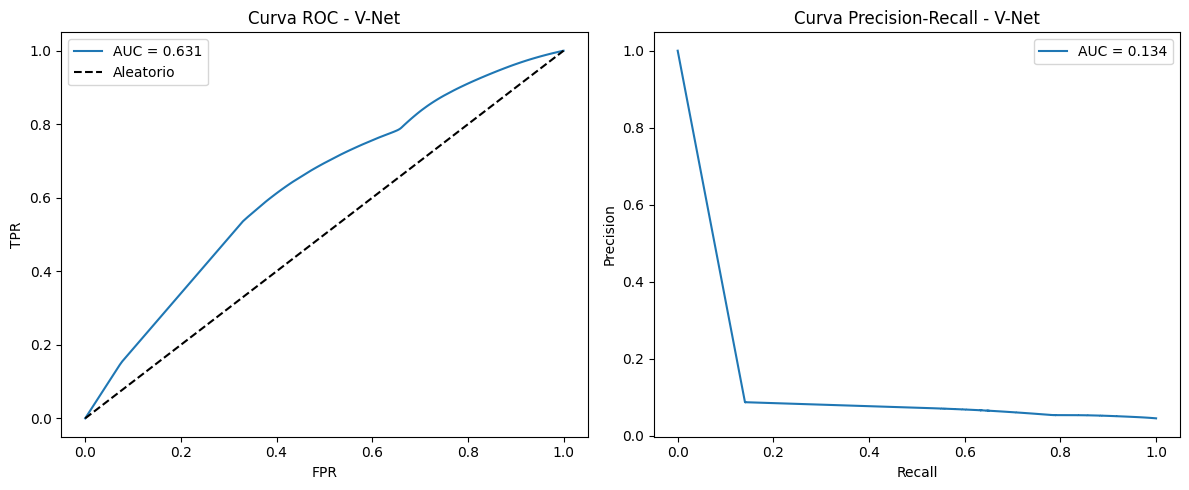

In [ ]:
mostrar_curvas_roc_pr("vnet_pred.npz", "V-Net")

C:\Users\Pumacens\AppData\Local\Temp\ipykernel_21124\1317268308.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


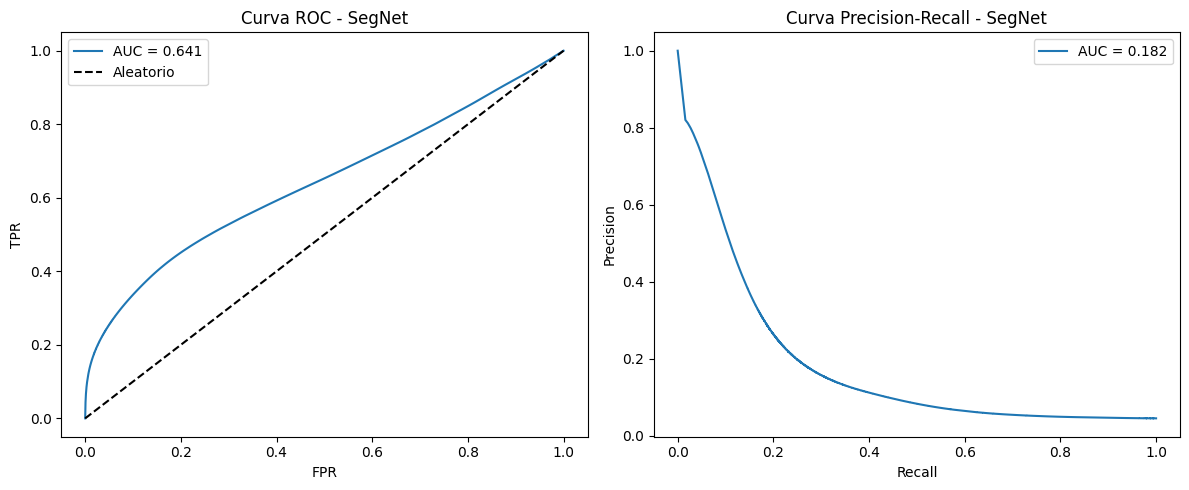

In [ ]:
mostrar_curvas_roc_pr("segnet_pred.npz", "SegNet")

C:\Users\Pumacens\AppData\Local\Temp\ipykernel_21124\1317268308.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


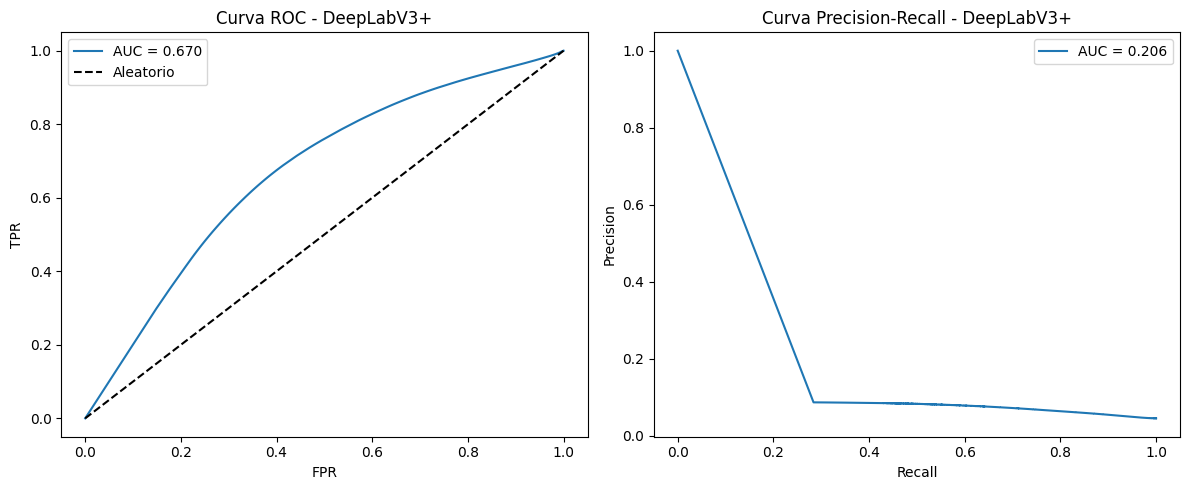

In [ ]:
mostrar_curvas_roc_pr("deeplab_pred.npz", "DeepLabV3+")

C:\Users\Pumacens\AppData\Local\Temp\ipykernel_21124\1317268308.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


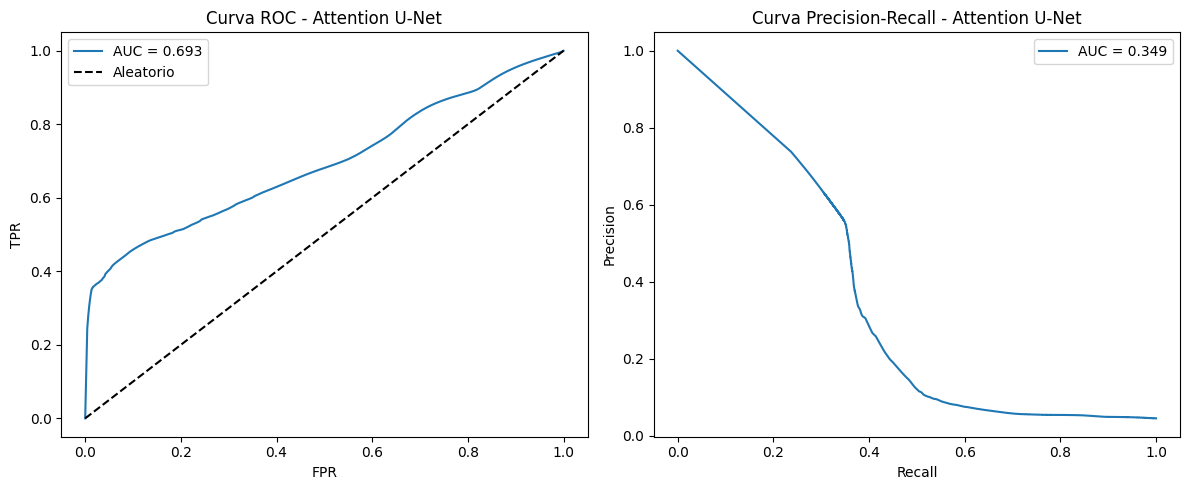

In [ ]:
mostrar_curvas_roc_pr("attention_unet_pred.npz", "Attention U-Net")


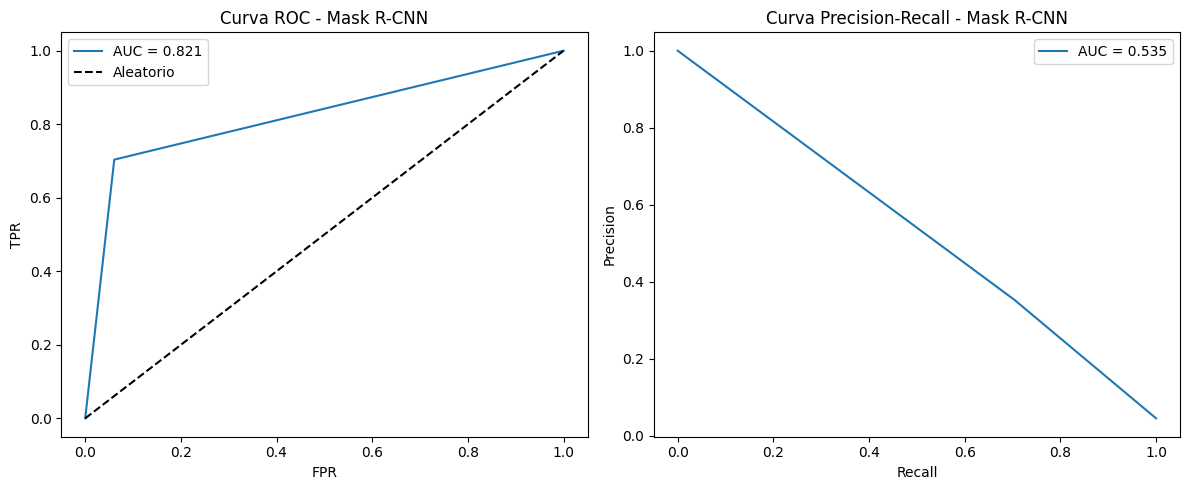

In [ ]:
mostrar_curvas_roc_pr("maskrcnn_pred.npz", "Mask R-CNN")


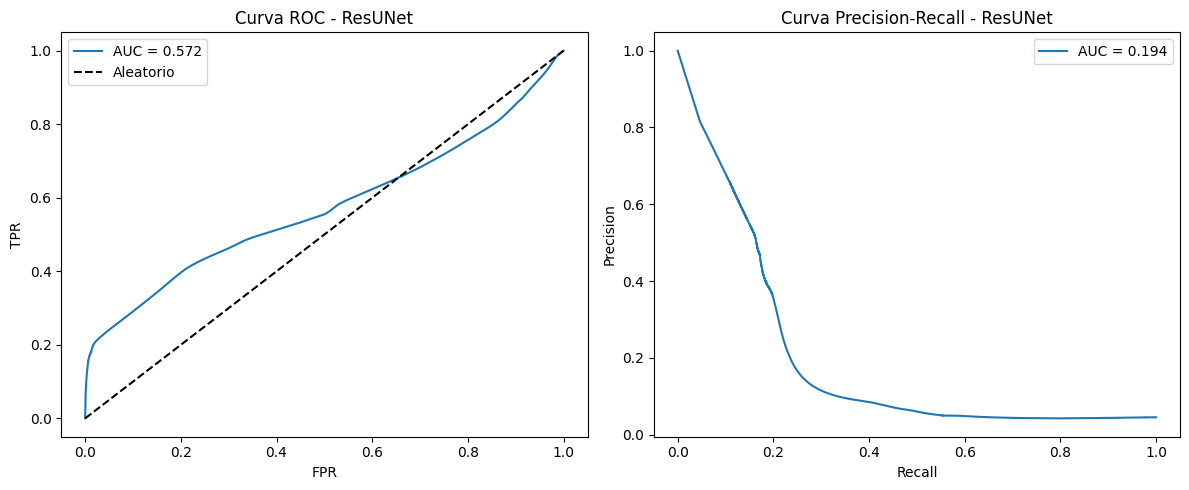

In [ ]:
mostrar_curvas_roc_pr("resunet_pred.npz", "ResUNet")


C:\Users\Pumacens\AppData\Local\Temp\ipykernel_21124\1317268308.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


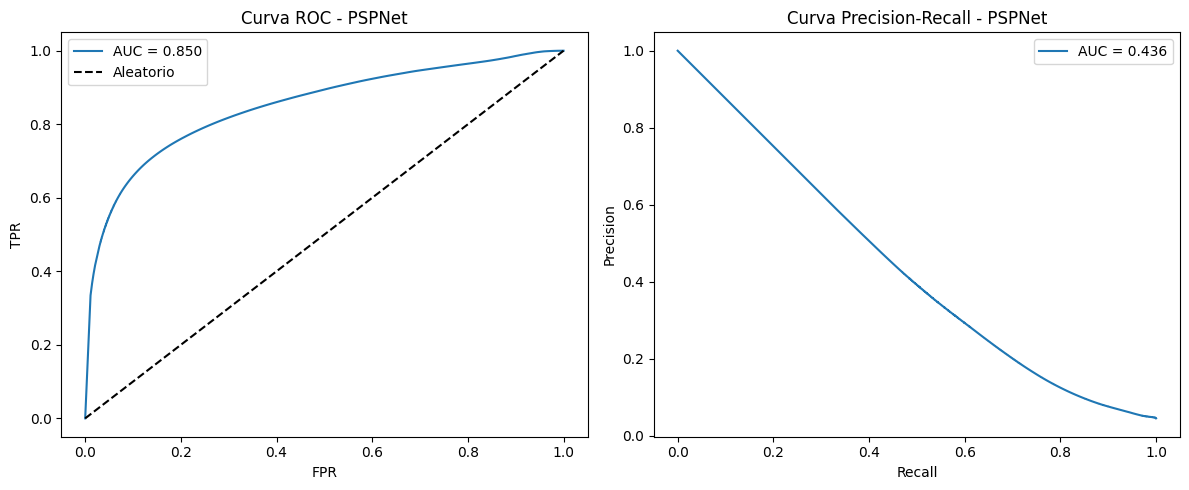

In [ ]:
mostrar_curvas_roc_pr("pspnet_pred.npz", "PSPNet")


C:\Users\Pumacens\AppData\Local\Temp\ipykernel_21124\1317268308.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


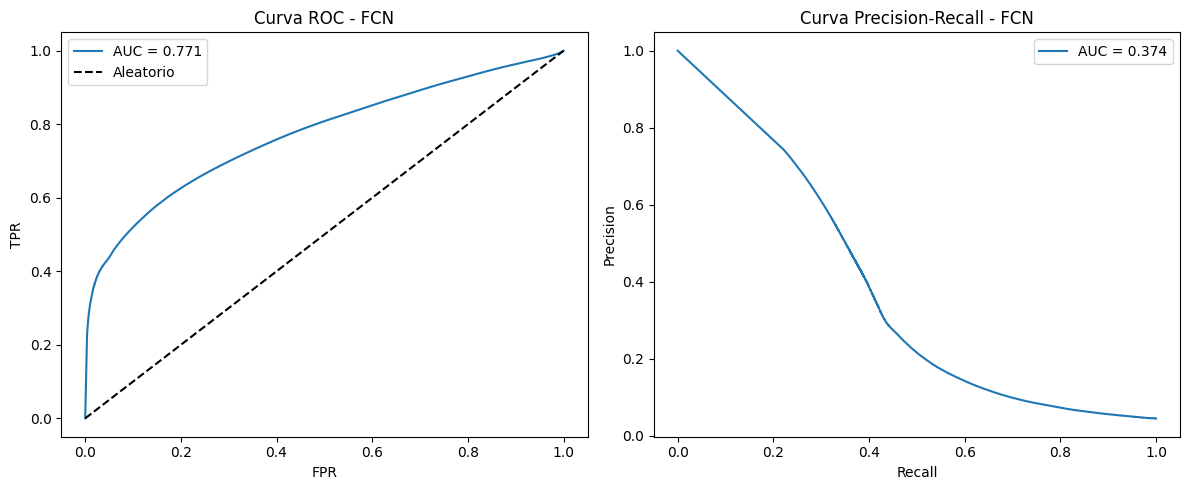

In [ ]:
mostrar_curvas_roc_pr("fcn_pred.npz", "FCN")


C:\Users\Pumacens\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


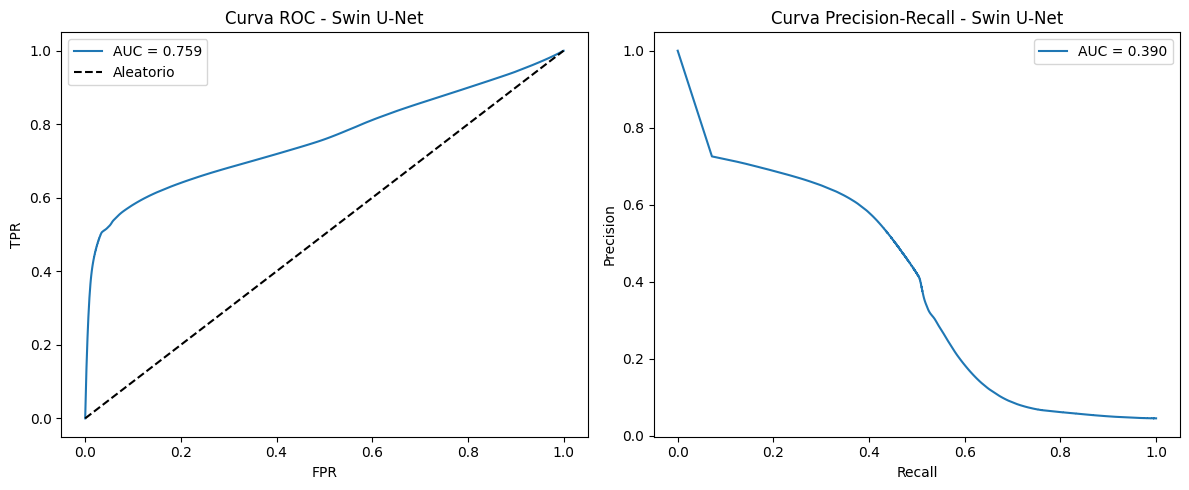

In [ ]:
mostrar_curvas_roc_pr("swin_unet_pred.npz", "Swin U-Net")


- **U-Net**
    - ROC AUC = 0.698: desempeño moderado, con capacidad discriminativa aceptable.

    - PR AUC = 0.297: baja. El modelo tiende a sacrificar precisión a medida que aumenta el recall.

    - Comentario: U-Net logra un equilibrio aceptable en clasificación general, pero sufre para mantener precisión cuando intenta cubrir más área positiva.

- **V-Net**
    - ROC AUC = 0.631: cercano al azar, indica baja discriminación.

    - PR AUC = 0.134: extremadamente baja, lo que indica que el modelo produce muchos falsos positivos.

    - Comentario: Este modelo presenta un rendimiento muy pobre en segmentación; incluso al aumentar el recall, la precisión colapsa.

- **SegNet**

    - ROC AUC = 0.641: desempeño bajo, pero por encima del azar. La capacidad de distinguir entre píxeles positivos y negativos es limitada.

    - PR AUC = 0.182: muy baja. El modelo presenta dificultades significativas para mantener una buena precisión cuando intenta aumentar el recall.

    - Comentario: SegNet tiene un comportamiento débil en términos de segmentación vascular. Aunque discrimina ligeramente mejor que V-Net, el modelo comete muchos falsos positivos y no logra un buen compromiso entre precisión y sensibilidad, lo cual se refleja claramente en la curva Precision-Recall.

- **DeepLabV3+**
    - ROC AUC = 0.670: levemente mejor que V-Net, pero aún débil.

    - PR AUC = 0.206: igualmente baja.

    - Comentario: El modelo no logra un buen balance entre detección y precisión, similar a V-Net.

- **Attention U-Net**
    - ROC AUC = 0.693: similar a U-Net, pero no superior.

    - PR AUC = 0.349: mejor que U-Net y DeepLabV3+, aunque sigue siendo limitado.

    - Comentario: El uso de atención mejora ligeramente la calidad de la segmentación en términos de precisión y recall.

- **Mask R-CNN**
    - ROC AUC = 0.821: el más alto entre todos los modelos.

    - PR AUC = 0.535: también el mejor valor.

    - Comentario: Este modelo tiene un rendimiento sobresaliente, identificando correctamente una gran proporción de verdaderos positivos sin perder precisión. Se adapta bien a la tarea incluso con clases desbalanceadas.

- **ResUNet**
    - ROC AUC = 0.572: el peor valor ROC de todos los modelos.

    - PR AUC = 0.194: también bajo.

    - Comentario: Aunque tiene buena precisión puntual en métricas previas, el modelo no logra detectar correctamente los vasos a nivel de recall, lo cual se evidencia aquí.

- **PSPNet**
    - ROC AUC = 0.850: el mejor valor ROC.

    - PR AUC = 0.436: también alto.

    - Comentario: PSPNet presenta uno de los mejores compromisos entre sensibilidad y precisión, especialmente para clases pequeñas. Ideal para segmentación detallada.

- **FCN**
    - ROC AUC = 0.771: alto y consistente.

    - PR AUC = 0.374: valor intermedio, por encima de muchos modelos clásicos.

    - Comentario: FCN ofrece un rendimiento sólido y consistente. No destaca como PSPNet o Mask R-CNN, pero claramente supera a U-Net y DeepLabV3+.

- **Swin U-Net**
    - ROC AUC = 0.759: alto.

    - PR AUC = 0.390: también bueno.

    - Comentario: El modelo Swin U-Net mantiene una muy buena discriminación general y una buena relación precisión-recall. Su arquitectura basada en transformers parece efectiva incluso en este dataset reducido.

Los modelos Mask R-CNN, PSPNet y Swin U-Net presentan las mejores curvas, tanto en ROC como en Precision-Recall. Modelos como V-Net, DeepLabV3+ y ResUNet muestran curvas planas o con caídas abruptas, señal de mala capacidad de generalización y muchos errores de tipo I o II. La curva Precision-Recall fue especialmente útil para identificar el verdadero poder del modelo en este problema desbalanceado.



#### Mapa de Error

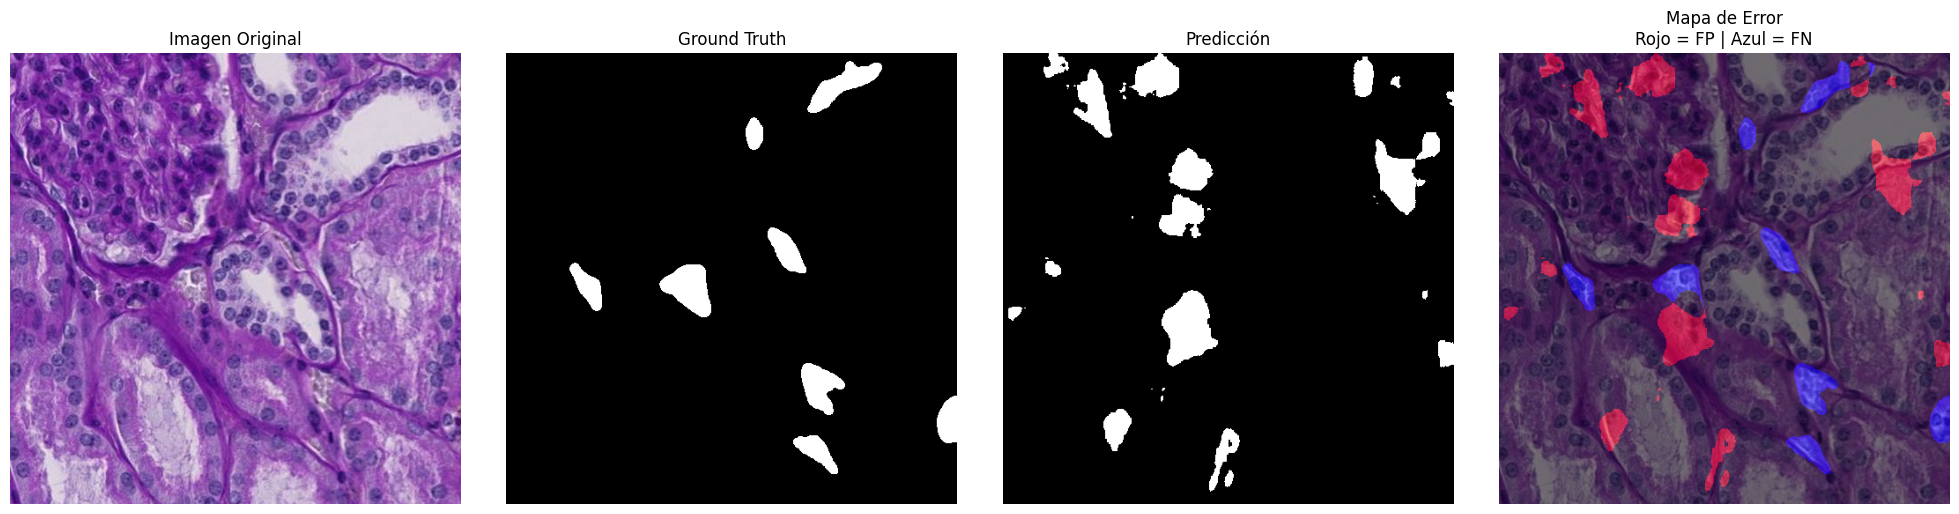

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

def mostrar_mapa_error(tid, ruta_npz, indice=0, ruta_imagen="train"):
    # Cargar imagen original
    img_path = os.path.join(ruta_imagen, f"{tid}.tif")
    img = tiff.imread(img_path).astype(np.float32) / 255.0
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)  # convertir a RGB

    # Cargar predicciones
    datos = np.load(ruta_npz)
    p = datos["p"][indice, 0]
    t = datos["t"][indice, 0]

    pred = (p >= 0.5).astype(np.uint8)
    gt = HuBMAP([])._mask(tid)

    # Calcular FP y FN
    FP = (pred == 1) & (gt == 0)
    FN = (pred == 0) & (gt == 1)

    # Crear imagen en blanco (RGB) del error
    error_img = np.zeros((512, 512, 3), dtype=np.float32)
    error_img[FP] = [1, 0, 0]   # Rojo para FP
    error_img[FN] = [0, 0, 1]   # Azul para FN

    # Mostrar imagen original, GT, predicción y mapa de error
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img)
    axes[0].set_title("Imagen Original")

    axes[1].imshow(gt, cmap='gray')
    axes[1].set_title("Ground Truth")

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Predicción")

    axes[3].imshow(img)
    axes[3].imshow(error_img, alpha=0.5)
    axes[3].set_title("Mapa de Error\nRojo = FP | Azul = FN")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Ejemplo de uso:
mostrar_mapa_error("0006ff2aa7cd", "swin_unet_pred.npz", indice=0)